In [1]:
"""
Resnet-18 for classifying roof materials from PlanetScope SuperDove imagery
Case study in Washington, D.C. 
"""

import os, time, glob
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms, utils
from torchsat.models.classification import resnet18

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from fiona.crs import from_epsg
from shapely.geometry import box

import warnings
warnings.filterwarnings("ignore")

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
print(f'Projected CRS: {proj}')

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
maindir = '/home/jovyan/opp-data' # jetstream2

print("Successfully imported all packages!")

Projected CRS: EPSG:32618
Successfully imported all packages!


In [2]:
class RoofImageDataset_Planet(Dataset):
    """Class to handle PlanetScope SuperDove imagery for Resnet-18"""

    def __init__(self, gdf, img_path, n_bands, img_dim, transform=None):
        """
        Args:
            gdf: Geodataframe containing 'geometry' column and 'class_code' column
            img_path: the path to the PlanetScope SuperDove composite image (single mosaic file)
                - see 'psscene-prep.py' for spectral indices calculation
            imgdim (int): Image dimension for CNN implementation
            transform (callable, optional): Optional transform to be applied on a sample

        Returns image chunks with class labels
        """

        if not os.path.exists(img_path):
            raise ValueError(f'Image does not exists: {img_path}')

        self.geometries = [p.centroid for p in gdf.geometry.values] # gather centroid geoms
        self.img_path = img_path # path to image data
        self.img_dim = img_dim # resnet window dimension, defaults to 64
        self.n_bands = n_bands # number of bands in the input image
        self.Y = gdf.code.values # class codes (numeric)
        self.transform = transform
        
    def __len__(self):
        return len(self.geometries)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the geometry of the idx (centroid)
        geom = self.geometries[idx]

        try:
            sample = self.sample_image(geom)  # run the sampling function
        
            cc = self.Y[idx]  # get the class codes
            if type(cc) != int:
                cc = cc.astype('uint8') # make sure the cc is an integer
            
            # Ensure the sample has the correct dimensions
            assert sample.shape == (self.n_bands, self.img_dim, self.img_dim), f'Invalid sample shape: {sample.shape}'

            if self.transform:
                sample = self.transform(sample)
                        
        except Exception as e:
            raise ValueError(e)
            print(f"Skipping invalid sample at index: {idx}")
            sample = torch.from_numpy(np.zeros((self.n_bands, int(self.img_dim), int(self.img_dim))))
            cc = 255 # highest int8 number to be flagged
         
        # Convert the sample array to a Torch object
        sample = torch.from_numpy(sample)

        # Return the sample and the label as torch objects
        return {'image': sample.type(torch.FloatTensor),
                'code': torch.tensor(cc).type(torch.LongTensor)}

    
    def sample_image(self, geom):
        """ Sample the image at each geometry for the specified image chunk size (window) """
 
        N = self.img_dim # window size to be used for cropping
            
        # Use the windows.from_bounds() method to return the window
        # Returns image chunks from training data locations
        with rio.open(self.img_path) as src:
            py, px = src.index(geom.x, geom.y)
            window = rio.windows.Window(px - N // 2, py - N // 2, N, N)
            # print(window)
            
            # Read the data in the window
            # clip is a nbands * N * N numpy array
            clip = src.read(window=window, indexes=list(range(1, self.n_bands + 1)))

            del py, px, window # clean up

        # Convert the image chunk to a numpy array
        clip_arr = np.array(clip)

        # Check if the image chunk has valid data
        if clip_arr.sum() > 0:
            # Mask invalid values in each band independently
            ans = np.ma.masked_equal(clip_arr, 0).filled(0)
        else:
            ans = clip_arr
        
        del clip, clip_arr # clean up
        return ans


def make_good_batch(batch):
    """
    Removes bad samples if image dimensions do not match.
    Args:
        - batch: list of dictionaries, each containing 'image' tensor and 'code' tensor
    returns: list of dictionaries same as input with samples having non-matching image dims removed
    """

    _idx = torch.where(batch['code'] != 255)[0] # good batches

    new_batch = {}
    new_batch['image'] = batch['image'][_idx]
    new_batch['code'] = batch['code'][_idx]

    return new_batch


def balance_sampling(df, ratio=5, strategy='undersample'):
    """
    Generate balanced sample from training data based on the defined ratio.
    This can be done with majority undersampling or minority oversampling ('strategy' parameter)
    Args:
        - df: the dataframe with rows as training data
        - ratio: the sampling ration (i.e., 5:1 for minority classes default)
    Returns:
        - random sample with class ratios as defined
    """
    
    # Get the class counts
    class_counts = df['class_code'].value_counts()
    min_class_count = class_counts.min()
    
    # Calculate the target count for each class based on the ratio
    target_count = {
        class_label: min(min_class_count * ratio, len(df[df['class_code'] == class_label])) 
                        for class_label in class_counts.index
    }
    
    # Create an empty list to store balanced dataframes
    balanced_dfs = []
    for class_label in class_counts.index:
        class_df = df[df['class_code'] == class_label]
        if strategy == 'undersample':
            # Under-sample the majority class
            balanced_class_df = resample(
                class_df, replace=False, n_samples=target_count[class_label], random_state=42)
        elif strategy == 'oversample':
            # Over-sample the minority class
            balanced_class_df = resample(
                class_df, replace=True, n_samples=target_count[class_label], random_state=42)
        balanced_dfs.append(balanced_class_df)

    # Concatenate the results by class
    balanced_df = pd.concat(balanced_dfs)
    return balanced_df


def split_training_data(gdf, ts, vs):
    """ 
    Splits dataframe into train, test, and validation samples with the defined ratios 
    Args:
        - gdf: training samples (geo data frame)
        - ts: test size #
        - vs: validation size #
    Returns:
        train, test, and validation dataframes
    """
    
    train_df, test_df, val_df = [], [], []

    for cl in gdf.class_code.unique():
        
        # subset to class
        _gdf = gdf.loc[gdf.class_code == cl]
        
        # get train and test validation arrays. 
        # test array is validation array split in half.
        _train, _valtest = train_test_split(_gdf, random_state=27, test_size=ts)
        train_df.append(_train)
        
        _val, _test = train_test_split(_valtest, random_state=27, test_size=vs)
        test_df.append(_test)
        val_df.append(_val)

    # Concatenate the samples across classes
    all_train_df = pd.concat(train_df)
    all_train_df = gpd.GeoDataFrame(all_train_df, crs=gdf.crs)
    
    all_val_df = pd.concat(val_df)
    all_val_df = gpd.GeoDataFrame(all_val_df, crs=gdf.crs)
    
    all_test_df = pd.concat(test_df)
    all_test_df = gpd.GeoDataFrame(all_test_df, crs=gdf.crs)

    return all_train_df, all_val_df, all_test_df


print("Class and functions ready to use!")

Class and functions ready to use!


In [3]:
os.chdir('/home/jovyan')
print(os.getcwd())
print(os.listdir(os.getcwd()))

/home/jovyan
['.bashrc', '.bash_logout', '.profile', 'opp-rooftop-mapping', '.ipynb_checkpoints', '.npm', '.nv', '.jupyter', '.ipython', 'cyverse-utils', '.gitconfig', 'opp-data', '.ssh', '.local', '.config', 'work', '.condarc', 'environment.yml', '.conda', '.pip', '.cache']


In [4]:
# Load the training data (footprints)
ref_path = 'opp-data/dc_data_reference_footprints.gpkg'
ref = gpd.read_file(ref_path)
ref.head()

,class_code,areaUTMsqft,uid,description,code,geometry
0,CS,357.783709,1CS,Composition Shingle,0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,CS,918.640862,2CS,Composition Shingle,0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,CS,1383.414170,3CS,Composition Shingle,0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,CS,836.410297,4CS,Composition Shingle,0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,CS,330.514264,5CS,Composition Shingle,0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [5]:
# Observe the class imbalance in the reference data
print(f"Class counts:\n\n{ref.description.value_counts()}\n")

Class counts:

description
Metal                  29651
Composition Shingle    27687
Slate                  11080
Urethane                1018
Wood shake/shingle       866
Tile                     617
Shingle                  589
Name: count, dtype: int64



In [6]:
ref['code'], _ = pd.factorize(ref['class_code']) # create a factorized version
print(ref['class_code'].value_counts())  # check the counts

class_code
ME    29651
CS    27687
SL    11080
UR     1018
WS      866
TL      617
SH      589
Name: count, dtype: int64


In [7]:
# Create a dictionary mapping class_code to code
code_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WS': 5, 'SH': 6}
Description map: 
{'CS': 'Composition Shingle', 'ME': 'Metal', 'SL': 'Slate', 'UR': 'Urethane', 'TL': 'Tile', 'WS': 'Wood shake/shingle', 'SH': 'Shingle'}


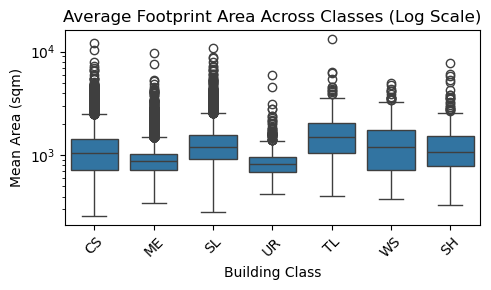

In [8]:
# Box plot for mean footprint area across classes
plt.figure(figsize=(5, 3))
sns.boxplot(x='class_code', y='areaUTMsqft', data=ref)

# Set the y-axis to log scale
plt.yscale('log')

plt.title('Average Footprint Area Across Classes (Log Scale)')
plt.ylabel('Mean Area (sqm)')
plt.xlabel('Building Class')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [9]:
def calc_longest_side(geom):
    """ Calculate the longest side length of a polygon """
    # Get the minimum rotated rectangle (bounding box)
    min_rect = geom.minimum_rotated_rectangle 
    coords = list(min_rect.exterior.coords) # coordinate bounds
    
    # Calculate the distances between consecutive rectangle vertices
    side_lens = [np.linalg.norm(np.array(coords[i]) - np.array(coords[i-1])) for i in range(1, len(coords))]

    mean_side_length = np.mean(side_lens)
    std_side_length = np.std(side_lens)
    longest_side_length = max(side_lens)
    
    # Return the longest side
    return mean_side_length, std_side_length, longest_side_length

def footprint_area_stats(group, pct=90):
    """ computes footprint stats based on the area and shape """
    # Get the average footprint area (m2) and side length (m)
    mean_area = group['areaUTMsqft'].mean() * 0.092903
    # Get the Nth percentile building area and side length
    pct_area = np.percentile(group['areaUTMsqft'], pct) * 0.092903  # Convert sqft to sqm

   # Calculate the longest side for each polygon in the group (mean, std, max)
    longest_sides = group['geometry'].apply(calc_longest_side)
    
    # Separate the tuple into individual lists for mean, std, and max side lengths
    mean_sides = longest_sides.apply(lambda x: x[0])
    std_sides = longest_sides.apply(lambda x: x[1])
    max_sides = longest_sides.apply(lambda x: x[2])
    
    # Calculate the Nth percentile of the longest sides
    pct_longest_side = np.percentile(max_sides, pct)
    
    return pd.Series({
        'mean_area': mean_area,
        f'pct{pct}_area': pct_area,
        'mean_side_length': mean_sides.mean(),
        'std_side_length': std_sides.mean(),
        'max_side_length': max_sides.max(),
        f'pct{pct}_longest_side': pct_longest_side
    })

# Calculate the longest side length of the building
area_stats = ref.groupby('class_code').apply(footprint_area_stats).reset_index()
area_stats

,class_code,mean_area,pct90_area,mean_side_length,std_side_length,max_side_length,pct90_longest_side
0,CS,106.067916,170.359535,10.971056,2.602532,60.850765,18.061418
1,ME,83.614598,113.074503,10.599350,4.676626,49.074508,19.857406
2,SH,115.680340,186.108988,11.673437,3.162172,57.381862,19.143755
3,SL,122.038118,189.170671,12.024882,2.274018,60.865129,19.430261
4,TL,150.720654,231.695941,13.387741,3.069401,90.677342,21.238916
5,UR,80.790722,108.122005,10.713653,5.107872,35.502084,20.192619
6,WS,124.480158,214.561209,11.858802,2.529816,35.161554,19.246585


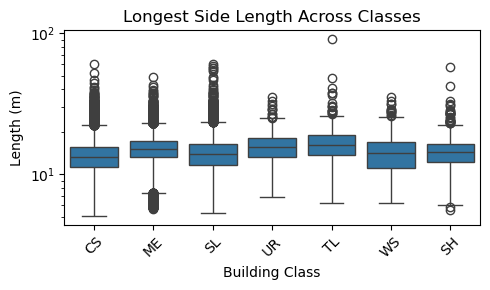

In [10]:
ref['longest_side_len'] = ref.geometry.apply(lambda geom: calc_longest_side(geom)[2])

# Box plot for mean footprint area across classes
plt.figure(figsize=(5, 3))
sns.boxplot(x='class_code', y='longest_side_len', data=ref)

# Set the y-axis to log scale
plt.yscale('log')

plt.title('Longest Side Length Across Classes')
plt.ylabel('Length (m)')
plt.xlabel('Building Class')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [11]:
# Identify 'pure' training locations

In [12]:
print(ref.crs)

EPSG:32618


In [13]:
print(area_stats['pct90_longest_side'].mean() * 4)

78.38340521114313


In [14]:
# # Create centroids
# ref_pt = ref.copy()
# ref_pt = ref_pt.to_crs(epsg=32618) # UTM Zone 18N
# ref_pt['geometry'] = ref_pt['geometry'].centroid

# # Define the window size and half window (for boxes)
# window_size = 78 # 4 times the average 90th pct side length
# half_window = window_size / 2

# training_windows = [] # image windows with >50% of specific roof type
# training_roof_types = [] # roof type codes for valid windows

# # Loop through each footprint individually
# for geom, roof_type in zip(ref.geometry, ref['class_code']):

#     centroid = geom.centroid # footprint centroid
    
#     # calculate the image window (64x64)
#     window = box(centroid.x - half_window, centroid.y - half_window,
#                  centroid.x + half_window, centroid.y + half_window)

#     # Intersect with centroids to get class count within window
#     intersect = ref_pt[ref_pt.intersects(window)]
    
#     # Get the total count and count for the class
#     total_count = len(intersect)
#     class_count = len(intersect[intersect['class_code'] == roof_type])

#     # Check if there is at least 50% of the roof type in that window
#     if total_count > 0 and (class_count / total_count) > 0.50:
#         training_windows.append(centroid)
#         training_roof_types.append(roof_type)

#     del intersect, window, centroid

# # Create a GeoDataFrame for the training windows with roof types
# ref_windows = gpd.GeoDataFrame({
#     'geometry': training_windows, 
#     'class_code': training_roof_types
# }, crs=ref.crs)

# # Create a numeric code for the training data frame
# ref_windows['code'], _ = pd.factorize(ref_windows['class_code'])
# print("Spatial filtering complete.")

In [15]:
# # Save out
# os.getcwd()
# out_file = 'opp-data/dc_rooftop_materials_training_windows.gpkg'
# ref_windows.to_file(out_file)

# del training_windows, training_roof_types, ref_pt
# gc.collect()

In [16]:
# # Plot the training locations with colors based on roof type
# fig, ax = plt.subplots(figsize=(6, 6))
# ref_windows.plot(column='class_code', ax=ax, legend=True, cmap='Set1', edgecolor='black')
# plt.title('Training Locations by Roof Material Type')
# plt.show()

In [17]:
# print(ref_windows.class_code.value_counts())
# # Create a dictionary mapping class_code to code
# class_mapping = dict(zip(ref_windows['class_code'], ref_windows['code']))
# print(class_mapping)

In [18]:
# Perform balanced sampling (random undersampling)
ref_bal = balance_sampling(ref, ratio=10, strategy='undersample')
ref_bal.code.value_counts()

code
1    5890
0    5890
2    5890
3    1018
5     866
4     617
6     589
Name: count, dtype: int64

In [19]:
# Split the train/test data
train_df, val_df, test_df = split_training_data(ref_bal, ts=0.3, vs=0.2)

# Print the class distribution in training and validation sets to verify stratification
print("Train class distribution:\n", train_df['code'].value_counts())
print("Validation class distribution:\n", val_df['code'].value_counts())
print("Test class distribution:\n", test_df['code'].value_counts())

Train class distribution:
 code
1    4123
0    4123
2    4123
3     712
5     606
4     431
6     412
Name: count, dtype: int64
Validation class distribution:
 code
1    1413
0    1413
2    1413
3     244
5     208
4     148
6     141
Name: count, dtype: int64
Test class distribution:
 code
1    354
0    354
2    354
3     62
5     52
4     38
6     36
Name: count, dtype: int64


In [20]:
# Load our image data to check on the format
stack_da_fp = os.path.join('opp-data/dc_0623_psscene8b_final_norm.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
n_bands = stack_da.values.shape[:1][0]
print(
    f"shape: {stack_da.rio.shape}\n"
    f"bands: {n_bands}\n"
    f"resolution: {stack_da.rio.resolution()}\n"
    f"bounds: {stack_da.rio.bounds()}\n"
    f"sum: {stack_da.sum().item()}\n"
    f"CRS: {stack_da.rio.crs}\n"
    f"NoData: {stack_da.rio.nodata}\n"
    f"Array: {stack_da}"
)
del stack_da

shape: (8223, 6714)
bands: 6
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 8.181640625
CRS: EPSG:32618
NoData: None
Array: <xarray.DataArray (band: 6, y: 8223, x: 6714)> Size: 1GB
[331255332 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5')


In [21]:
# Set up the Resnet-18 model

n_bands = n_bands

# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model dev ...')

# Grab the number of classes
n_classes = ref_bal.class_code.unique().shape[0]
print(f'There are {n_classes} roof type classes.')

# Define the Resnet-18 model (in_channels = number of bands in the image)
model = resnet18(n_classes, in_channels=n_bands, pretrained=False)

# Make model parallel and on GPU
if torch.cuda.device_count() >= 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)
else:
    #ps_model = nn.DataParallel(ps_model)
    model = nn.DataParallel(model)
    print('Made cpu parallel')

Using cuda for model dev ...
There are 7 roof type classes.
Using  1 GPUs!


In [22]:
# Number of samples in each class
val_counts = list(train_df['code'].value_counts())
total_samples = sum(val_counts) # total number of samples
print(f'Total samples: {total_samples};\nValue counts: {val_counts}')

# Calculate class weights
class_weights = [total_samples / count for count in val_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class weights: {class_weights}")

class_weights_norm = class_weights / class_weights.sum()
print(f"Normalized class weights: {class_weights_norm}")

# Updated loss function with weights
criterion = nn.CrossEntropyLoss(weight=class_weights_norm).to(device)

Total samples: 14530;
Value counts: [4123, 4123, 4123, 712, 606, 431, 412]
Class weights: tensor([ 3.5241,  3.5241,  3.5241, 20.4073, 23.9769, 33.7123, 35.2670],
       device='cuda:0')
Normalized class weights: tensor([0.0284, 0.0284, 0.0284, 0.1647, 0.1935, 0.2720, 0.2846],
       device='cuda:0')


In [23]:
gc.collect()

23906

In [24]:
print(f"Train DataFrame indices: {val_df.index}")

Train DataFrame indices: Index([51921, 48525, 33151, 49839, 42219, 44603, 48673, 33910, 29488, 30411,
       ...
       71478, 71164, 71003, 70951, 70990, 71082, 71280, 71192, 71458, 71015],
      dtype='int64', length=4980)


In [25]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer
import itertools

# Define the grid of hyperparameters
param_grid = {
    'window_size': [36, 78, 144],
    'batch_size': [64, 128, 224],
    'learning_rate': [0.01, 0.001, 0.0001],
}

# Create a parameter grid
param_list = list(ParameterGrid(param_grid))
print(f'There are {len(param_list)} parameter combinations to test!')

There are 36 parameter combinations to test!


In [30]:
def resnet_tuning(params):
    ''' Parameter testing for simple Resnet-18 '''
    
    batch_size = params['batch_size']
    window_size = params['window_size']
    learning_rate = params['learning_rate']

    # Create the training samples
    train_ds = RoofImageDataset_Planet(train_df[['geometry', 'code']], stack_da_fp, n_bands=n_bands, img_dim=window_size)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    
    # Create the validation samples
    val_ds = RoofImageDataset_Planet(val_df[['geometry', 'code']], stack_da_fp, n_bands=n_bands, img_dim=window_size)
    val_loader = DataLoader(val_ds, batch_size=batch_size * 2, shuffle=False, num_workers=0, pin_memory=True)

    # Optimizer, learning rate scheduler, and scaler
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    scaler = torch.cuda.amp.GradScaler()  # initialize scaler for mixed precision
    
    # Initialize lists to track the losses for each epoch
    train_losses = [] # stores epoch train losses
    val_losses = [] # stores epoch validation losses
    # Initialize lists to track accuracy across epochs
    acc_ep = [] # stores the overall accuracy
    f1_ep = [] # stores f1-scores for each epoch/trial
    time_ep = [] # stores time to complete for each epoch/trial
    
    # Epoch loop
    for epoch in range(12):  # Adjust number of epochs as needed
        epoch_t0 = time.time()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Training loop
        model.train()

        batch_train_losses = [] # to store batch loss

        for idx, batch in enumerate(train_loader):
            # Ensure a good batch
            batch = make_good_batch(batch)
            
            # Extract samples (image chunk, target label)
            image, target = batch['image'].to(device), batch['code'].to(device)

            optimizer.zero_grad() # reset the gradient

            # Use mixed precision
            with torch.cuda.amp.autocast():
                output = model(image.float())
                loss = criterion(output, target.long())

            scaler.scale(loss).backward()  # Mixed precision backward pass
            scaler.step(optimizer)  # Optimizer step
            scaler.update()
            
            batch_train_losses.append((idx, loss.item())) # append to batch losses list

            del image, target, batch, output, loss

        # average loss for the epoch (across batches)
        train_loss = np.array(batch_train_losses)[:,1].mean()
        train_losses.append(train_loss)
            
        # Validation loop
        model.eval()
        
        with torch.no_grad():

            correct = 0
            all_labs = []
            all_preds = []
            batch_val_losses = []
            
            for idx, batch in enumerate(val_loader):
                # Ensure a good batch
                batch = make_good_batch(batch)
                
                # Extract samples
                image, target = batch['image'].to(device), batch['code'].to(device)

                # Get validation loss
                with torch.cuda.amp.autocast():
                    output = model(image.float())  # Forward pass with mixed precision
                    loss = criterion(output, target.long())  # Loss calculation
                # Append to the batch validation losses
                batch_val_losses.append((idx, loss.item()))
                
                # Predictions and number correct
                predicted = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += predicted.eq(target.view_as(predicted)).sum().item() # Number of correct
                
                # Store the labels
                all_labs.extend(target.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
    
                del image, target, batch, output
            
            val_loss = np.array(batch_val_losses)[:,1].mean()
            val_losses.append(val_loss)
        
        # Adjust the learning rate based on the validation loss
        lr_scheduler.step(val_loss)
        
        # Calculate the overall accuracy and F1-score for the trial
        trial_f1 = f1_score(all_labs, all_preds, average='weighted')
        trial_acc = 100. * correct / len(val_loader.dataset)
        f1_ep.append(trial_f1)
        acc_ep.append(trial_acc)

        # Store the time/epoch
        epoch_t1 = (time.time() - epoch_t0) / 60 # minutes
        time_ep.append(round(epoch_t1, 2))

        print(f"Epoch [{epoch+1}] completed.\n\tTrain Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f'\tWeighted F1-score (validation): {trial_f1:.4f}')
        print(f'\tTime to complete epoch: {epoch_t1:.2f}')

        gc.collect() # do a garbage cleanup
        torch.cuda.empty_cache()
        
    print(f"Trial complete. Epoch/min: {(sum(time_ep)/len(time_ep)):.2f}")
    print(f"\tAverage F1-score: {(sum(f1_ep)/len(f1_ep)):.4f}; Maximum F1-score: {max(f1_ep):.4f}")
    
    gc.collect() # garbage cleanup
    torch.cuda.empty_cache()
    
    return {
        'accuracy': acc_ep,
        'f1_score': f1_ep,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'time_epoch': time_ep
    }

print("Tuning function ready !")

Tuning function ready !


In [31]:
# Implementation

t0 = time.time()

# Create a blank data frame to store the results
results_df = pd.DataFrame(
    columns=[
        'trial', 'batch_size', 'window_size', 'learning_rate', 
        'epoch', 'accuracy', 'f1_score', 
        'train_loss', 'val_loss', 'time_ep'
    ])

# Perform the grid search
for i, params in enumerate(param_list):
    t00 = time.time()

    params = param_list[i]
    print(f"Testing parameters: {params}")

    # Run the trial, store the metrics
    metrics = resnet_tuning(params)

    t1 = (time.time() - t00) / 60 # minutes
    print(f"Total elapsed time for parameter combination {i}: {t1:.2f} minutes.")

    # Store epoch-wise metrics for each trial
    temp_df = pd.DataFrame({
        'trial': [i] * len(metrics['accuracy']),
        'batch_size': [params['batch_size']] * len(metrics['accuracy']),
        'window_size': [params['window_size']] * len(metrics['accuracy']),
        'learning_rate': [params['learning_rate']] * len(metrics['accuracy']),
        'epoch': list(range(1, len(metrics['accuracy']) + 1)),
        'accuracy': metrics['accuracy'],
        'f1_score': metrics['f1_score'],
        'train_loss': metrics['train_losses'],
        'val_loss': metrics['val_losses'],
        'time_ep': metrics['time_epoch']
    })

    results_df = pd.concat([results_df, temp_df], ignore_index=True)

    print("\n~~~~~~~~~~~~\n")
    
    # Clear unused variables
    del metrics
    gc.collect()  # Run garbage collection
    torch.cuda.empty_cache()  # Clear GPU memory

t2 = ((time.time() - t0) / 60) / 60
print(f"Total elapsed time for hyperparameter tuning: {t2:.2f} hours.")

Testing parameters: {'batch_size': 64, 'learning_rate': 0.01, 'window_size': 36}
Epoch [1] completed.
	Train Loss: 0.9009, Validation Loss: 1.4850
	Weighted F1-score (validation): 0.4871
	Time to complete epoch: 2.22
Epoch [2] completed.
	Train Loss: 0.5481, Validation Loss: 1.4376
	Weighted F1-score (validation): 0.5876
	Time to complete epoch: 2.20
Epoch [3] completed.
	Train Loss: 0.3532, Validation Loss: 1.5849
	Weighted F1-score (validation): 0.5839
	Time to complete epoch: 2.14
Epoch [4] completed.
	Train Loss: 0.2573, Validation Loss: 2.0911
	Weighted F1-score (validation): 0.5421
	Time to complete epoch: 2.13
Epoch [5] completed.
	Train Loss: 0.2776, Validation Loss: 1.8967
	Weighted F1-score (validation): 0.5543
	Time to complete epoch: 2.13
Epoch [6] completed.
	Train Loss: 0.4025, Validation Loss: 1.6533
	Weighted F1-score (validation): 0.6016
	Time to complete epoch: 2.14
Epoch [7] completed.
	Train Loss: 0.2106, Validation Loss: 1.6305
	Weighted F1-score (validation): 0.61

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

RuntimeError: DataLoader worker (pid(s) 312532) exited unexpectedly

In [ ]:
# save the results for further analysis
results_df.to_csv('opp-data/results/resnet18_grid_search_results.csv', index=False)

In [ ]:
gc.collect()

In [ ]:
# Retrieve the best parameters